# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
print(device)

cuda


In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-24 18:47:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [       <=>          ] 201.24M  18.7MB/s    in 1m 45s  

2024-10-24 18:48:47 (1.91 MB/s) - ‘data.txt.zip’ saved [211011981]



In [4]:
!ls -lh data.txt.zip


-rw-r--r-- 1 root root 202M Oct 24 18:48 data.txt.zip


In [5]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()

In [8]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [9]:
set_random_seed(42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))

y_mean = y_train.mean()
y_pred_const = np.full(len(y_test), y_mean)



Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
best_rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred_const))

In [11]:
print(f"RRidge: {rmse_for_model:.4f}")
print(f"best: {best_rmse_metric:.4f}")

RRidge: 9.5102
best: 10.8525


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [12]:
df = pd.read_csv('data.txt.zip', header=None)

subset_size = 463715
df_subset = df.sample(n=subset_size, random_state=42)

X = df_subset.iloc[:, 1:].values
y = df_subset.iloc[:, 0].values

split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device).view(-1, 1)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device).view(-1, 1)


In [13]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim).to(device)


In [14]:
if model is None:
    model = LinearRegressionModel(input_dim).to(device)

learning_rate = 0.01
num_epochs = 10

train_losses = []
test_losses = []
train_rmses = []
test_rmses = []

for epoch in range(num_epochs):
    model.zero_grad()

    outputs = model(X_train)
    loss = torch.mean((outputs - y_train) ** 2)

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    train_rmse = torch.sqrt(torch.mean((outputs - y_train) ** 2)).item()
    train_losses.append(loss.item())
    train_rmses.append(train_rmse)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test.to(device))
        test_loss = torch.mean((test_outputs - y_test.to(device)) ** 2)
        test_rmse = torch.sqrt(test_loss).item()
    model.train()

    test_losses.append(test_loss.item())
    test_rmses.append(test_rmse)

    print(f"{epoch+1} loss: {loss.item():.4f}, RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

1 loss: 3993600.7500, RMSE: 1998.3995, test RMSE: 1958.4579
2 loss: 3835457.5000, RMSE: 1958.4324, test RMSE: 1919.2906
3 loss: 3683576.2500, RMSE: 1919.2645, test RMSE: 1880.9067
4 loss: 3537710.0000, RMSE: 1880.8801, test RMSE: 1843.2905
5 loss: 3397620.2500, RMSE: 1843.2634, test RMSE: 1806.4265
6 loss: 3263077.7500, RMSE: 1806.3992, test RMSE: 1770.2999
7 loss: 3133863.5000, RMSE: 1770.2721, test RMSE: 1734.8956
8 loss: 3009766.2500, RMSE: 1734.8678, test RMSE: 1700.1997
9 loss: 2890583.0000, RMSE: 1700.1715, test RMSE: 1666.1975
10 loss: 2776119.5000, RMSE: 1666.1691, test RMSE: 1632.8755


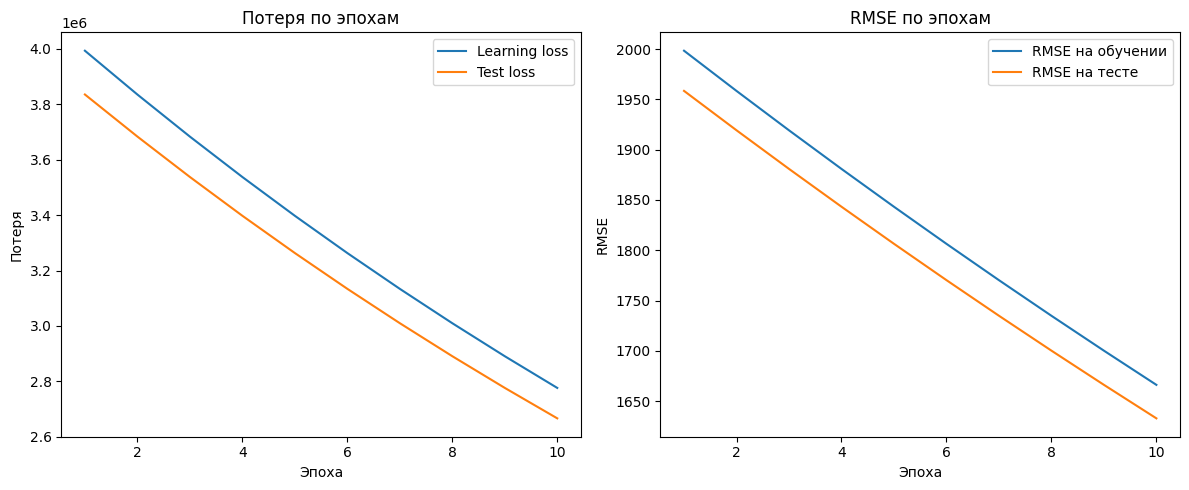

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Learning loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Потеря по эпохам')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_rmses, label='RMSE на обучении')
plt.plot(range(1, num_epochs + 1), test_rmses, label='RMSE на тесте')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.title('RMSE по эпохам')
plt.legend()

plt.tight_layout()
plt.show()


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [16]:
# Загрузка данных
df = pd.read_csv('data.txt.zip', header=None)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (463715, 90)
Размер тестовой выборки: (51630, 90)


In [17]:
# Стандартизация признаков
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Масштабирование целевой переменной
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Преобразование в тензоры PyTorch
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()


In [18]:
from torch.utils.data import TensorDataset, DataLoader

batch_size_train = 1024
batch_size_test = 512

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)


In [19]:
# Определение архитектуры нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
model = NeuralNetwork(input_dim).to(device)


In [20]:
# Оптимизатор и функция потерь
learning_rate = 0.1 # Используем более высокий learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [21]:
def train(model, optimizer, criterion, train_loader, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs}", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def evaluate(model, criterion, data_loader, scaler_y):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)

            outputs = model(X_batch)
            predictions.append(outputs.cpu())
            targets.append(y_batch.cpu())

    predictions = torch.cat(predictions).numpy()
    targets = torch.cat(targets).numpy()

    # Инвертируем масштабирование
    predictions = scaler_y.inverse_transform(predictions)
    targets = scaler_y.inverse_transform(targets)

    rmse = np.sqrt(mean_squared_error(targets, predictions))
    return rmse


In [22]:
num_epochs = 6
train_losses = []
train_rmses = []
test_rmses = []

Эпоха 6/6
Потеря на обучении: 0.6058
RMSE на обучении: 8.3836
RMSE на тесте: 8.7936


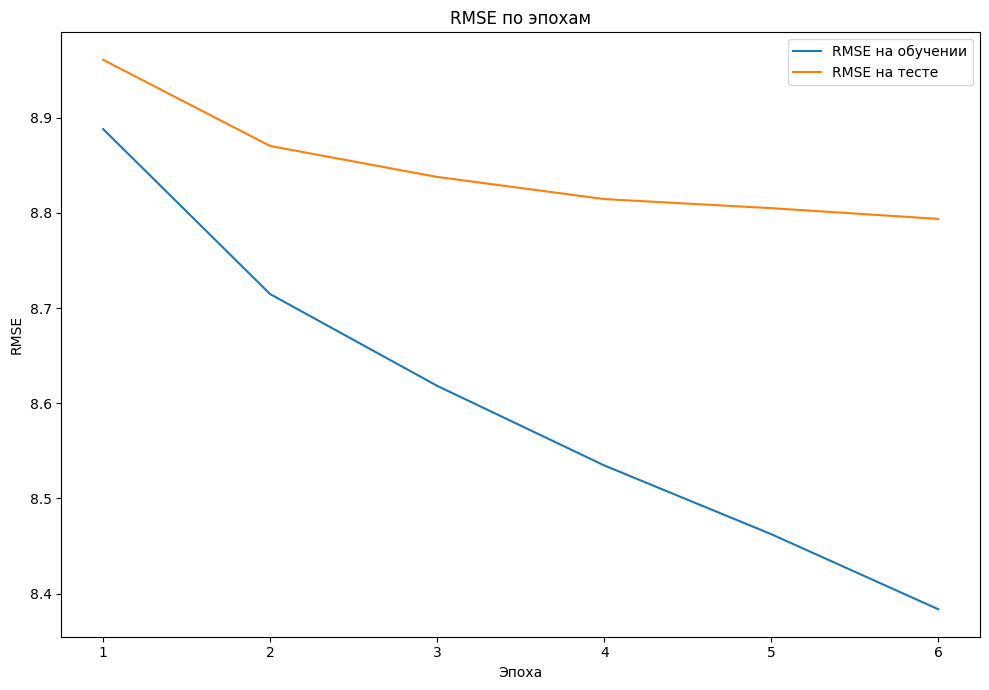

In [23]:
for epoch in range(num_epochs):
    set_random_seed(42)  # Фиксация семени для воспроизводимости

    # Обучение
    train_loss = train(model, optimizer, criterion, train_loader, epoch, num_epochs)
    train_losses.append(train_loss)

    # Оценка на обучающей выборке
    train_rmse = evaluate(model, criterion, train_loader, scaler_y)
    train_rmses.append(train_rmse)

    # Оценка на тестовой выборке
    test_rmse = evaluate(model, criterion, test_loader, scaler_y)
    test_rmses.append(test_rmse)

    # Вывод прогресса
    clear_output(wait=True)
    print(f"Эпоха {epoch+1}/{num_epochs}")
    print(f"Потеря на обучении: {train_loss:.4f}")
    print(f"RMSE на обучении: {train_rmse:.4f}")
    print(f"RMSE на тесте: {test_rmse:.4f}")

    # Построение графиков
    plt.figure(figsize=(10, 7))


    plt.plot()
    plt.plot(range(1, epoch+2), train_rmses, label='RMSE на обучении')
    plt.plot(range(1, epoch+2), test_rmses, label='RMSE на тесте')
    plt.xlabel('Эпоха')
    plt.ylabel('RMSE')
    plt.title('RMSE по эпохам')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [24]:
final_test_rmse = evaluate(model, criterion, test_loader, scaler_y)
print(f"Итоговое RMSE на тестовой выборке: {final_test_rmse:.4f}")


Итоговое RMSE на тестовой выборке: 8.7936


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Начал я с вот такой модели

```python
nn.Sequential(
    nn.Linear(input_dim, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
```

**Гиперпараметры:**

- **Learning rate:** 0.001
- **batch_size_train:** 512
- **batch_size_test:** 128

RMSE примерно 8.86

Усложним модельку

**Архитектура:**

```python
nn.Sequential(
    nn.Linear(input_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
```

**Гиперпараметры:**

- **Learning rate:** 0.001
- **batch_size_train:** 512
- **batch_size_test:** 128

**Результат:** RMSE ~8.85

По сути ничего неизменилось

Осталось только одно... Посмотреть мем, давайте думайте, подсказывайте...

Что я сел делать

1. **Dropout:** Пробовал добавлять `Dropout` в скрытые слои с различными значениями (от 0.2 до 0.5). Это позволило избежать переобучения, но чет не очень помогло

2. **Изменение размера батчей:** Тестировал размеры батчей от 128 до 2048.

3. **Изменение Learning Rate:** Пробовал значения `learning rate` до 0.1 (от что-то типо 1е-5).


## Эксперимент 42 (я не считал)

```python
nn.Sequential(
    nn.Linear(input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
```

**Гиперпараметры:**

- **Learning rate:** 0.1
- **batch_size_train:** 1024
- **batch_size_test:** 512

**Результат:** RMSE 8.7936

Наверное можно было и лучше, но я 4 часа это делать, я устать



## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [26]:
model = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [27]:
def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    predicts = torch.ones(len(test_loader.dataset))
    return predicts

In [28]:
assert test_classification(model, criterion, test_loader).shape[0] == y_test.shape[0]

In [29]:
# ೭੧(❛〜❛✿)੭೨ Go forward!